In [1]:
from os import path
import sys
# if '/mnt/home/apricewhelan/projects/stellarstreams/' not in sys.path:
#     sys.path.append('/mnt/home/apricewhelan/projects/stellarstreams/')
if '/Users/adrian/projects/stellarstreams/' not in sys.path:
    sys.path.append('/Users/adrian/projects/stellarstreams/')

# Third-party
import astropy.coordinates as coord
from astropy.table import Table, vstack
from astropy.io import fits, ascii
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from scipy.optimize import minimize

import emcee
from pyia import GaiaData
import schwimmbad

import gala.coordinates as gc
import gala.dynamics as gd
from gala.dynamics import mockstream
import gala.integrate as gi
import gala.potential as gp
from gala.units import galactic
from gala.mpl_style import center_emph

from stellarstreams.modeling.trackfit import MockStreamModel

In [34]:
mw = gp.MilkyWayPotential()

In [3]:
galcen_frame = coord.Galactocentric(galcen_distance=8.1*u.kpc)

MSTO stars for over-plotting:

In [4]:
msto = GaiaData('../data/gd1-better-selection.fits')

## Prepare data:

In [5]:
tbl = Table.read('../output/rrl_bhb_bs_rgb_master.fits')

g = GaiaData(tbl)

rv = tbl['rv'].copy()
rv[~np.isfinite(rv)] = 0.

c = coord.SkyCoord(ra=tbl['ra']*u.deg, 
                   dec=tbl['dec']*u.deg,
                   distance=coord.Distance(distmod=tbl['DM']),
                   pm_ra_cosdec=tbl['pmra']*u.mas/u.yr,
                   pm_dec=tbl['pmdec']*u.mas/u.yr,
                   radial_velocity=rv*u.km/u.s)
c_gd1 = c.transform_to(gc.GD1)

# Only take stars with phi1 > -80
phi1_mask = c_gd1.phi1.wrap_at(180*u.deg) > -80*u.deg
c_gd1 = c_gd1[phi1_mask]
c = c[phi1_mask]
g = g[phi1_mask]
rv = rv[phi1_mask]
tbl = tbl[phi1_mask]

/Users/adrian/anaconda/lib/python3.6/site-packages/astropy/coordinates/distances.py:183: RuntimeWarning: invalid value encountered in less
  if not allow_negative and np.any(distance.value < 0):
/Users/adrian/anaconda/lib/python3.6/site-packages/astropy/coordinates/angles.py:642: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/adrian/anaconda/lib/python3.6/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/Users/adrian/anaconda/lib/python3.6/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/Users/adrian/anaconda/lib/python3.6/site-packages/astropy/coordinates/angles.py:642: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(self_angle < wrap_angle

In [6]:
cov_gd1 = gc.transform_pm_cov(c, g.get_cov()[:, 3:5, 3:5], gc.GD1)

In [7]:
dist = coord.Distance(distmod=np.random.normal(tbl['DM'], tbl['DM_error'], 
                                               size=(10000, len(tbl))))

In [8]:
data = Table()

data['phi1'] = c_gd1.phi1.wrap_at(180*u.deg)
data['phi1_ivar'] = 1 / (1*u.mas).to(u.deg)**2

data['phi2'] = c_gd1.phi2
data['phi2_ivar'] = 1 / (1*u.mas).to(u.deg)**2

data['distance'] = np.nanmean(dist, axis=0).to(u.kpc)
data['distance_ivar'] = 1 / np.nanstd(dist.view(u.Quantity).to(u.kpc), axis=0)**2
data['distance_ivar'][~np.isfinite(data['distance_ivar'])] = 0.

data['pm_phi1_cosphi2'] = c_gd1.pm_phi1_cosphi2
data['pm_phi1_cosphi2_ivar'] = 1 / (cov_gd1[:,0,0]*c_gd1.pm_phi1_cosphi2.unit**2)

data['pm_phi2'] = c_gd1.pm_phi2
data['pm_phi2_ivar'] = 1 / (cov_gd1[:,1,1]*c_gd1.pm_phi2.unit**2)

data['radial_velocity'] = tbl['rv'] * u.km/u.s
data['radial_velocity'][np.isnan(data['radial_velocity'])] = 0.
data['radial_velocity_ivar'] = 1 / (tbl['rv_error'] * u.km/u.s)**2

data = data.filled(fill_value=0)

---

In [9]:
_stream = np.load('../output/stream_model_-20.0.npy')
stream = gd.PhaseSpacePosition(pos=_stream[:, :3].T*u.kpc,
                               vel=_stream[:, 3:].T*u.km/u.s)

In [10]:
phi1_0 = -20*u.deg
w0_p0 = {'phi2': 3.53709061e-02,
         'distance': 8.897, 
         'pm_phi1_cosphi2': -10, 
         'pm_phi2': -2.27160328, 
         'radial_velocity': -1.38114555e+02}

# phi1_0 = -31.55*u.deg
# p0 = (0.26548956,  7.84480046, -12.82291498, -2.98120049, -70.18707527)

In [12]:
prog_mass = np.linspace(8e4, 1e3, 3001)
prog_mass[-300:] = 0

In [63]:
class MockStreamModelTest(MockStreamModel):
    potential_cls = {'halo': gp.NFWPotential,
                     'disk': gp.MiyamotoNagaiPotential}
    potential_units = galactic
    
    def potential_transform(self, pars):
        pars['halo']['m'] = np.log(pars['halo'].pop('m'))
        pars['halo']['r_s'] = np.log(pars['halo'].pop('r_s'))
        pars['disk']['m'] = np.log(pars['disk'].pop('m'))
    
    def potential_transform_inv(self, pars):
        pars['halo']['m'] = np.exp(pars['halo'].pop('m'))
        pars['halo']['r_s'] = np.exp(pars['halo'].pop('r_s'))
        pars['disk']['m'] = np.exp(pars['disk'].pop('m'))
    
    def potential_ln_prior(self, pars):
        ln_mh = np.log(pars['halo']['m'])
        if not 25 < ln_mh < 29.3:
            return -np.inf
        
        ln_r_s = np.log(pars['halo']['r_s'])
        if not 1 < ln_r_s < 4:
            return -np.inf
        
        c = pars['halo']['c']
        if not 0.5 < c < 1.5:
            return -np.inf
        
        ln_md = np.log(pars['disk']['m'])
        if not 23 < ln_md < 26:
            return -np.inf
        
        return 0.
    
potential_frozen = {'halo': {'a': 1., 'b': 1},
                    'disk': {'a': 3., 'b': 0.28}}
potential_p0 = {'halo': {'m': 6e11, 'r_s': 15., 'c': 1., 
                         **potential_frozen['halo']},
                'disk': {'m': 7.5e10,
                         **potential_frozen['disk']}}

In [64]:
model = MockStreamModelTest(
    data, stream_frame=gc.GD1(),
    integrate_kw=dict(dt=-1*u.Myr, n_steps=3000), 
    mockstream_fn=mockstream.dissolved_fardal_stream,
    mockstream_kw=dict(prog_mass=prog_mass*u.Msun, 
                       t_disrupt=-300*u.Myr,
                       release_every=1,
                       seed=42),
    phi1_0=phi1_0, galcen_frame=galcen_frame, 
    frozen={'potential': potential_frozen},
    phi1_lim=[-100, 20]*u.deg, phi1_binsize=2*u.deg)

In [65]:
model.frozen

{'potential': {'halo': {'a': 1.0, 'b': 1}, 'disk': {'a': 3.0, 'b': 0.28}}}

In [66]:
potential_p0

{'halo': {'m': 600000000000.0, 'r_s': 15.0, 'c': 1.0, 'a': 1.0, 'b': 1},
 'disk': {'m': 75000000000.0, 'a': 3.0, 'b': 0.28}}

In [67]:
# w0 = model.get_w0(**w0_p0)
# H = model.get_hamiltonian(**potential_p0)
# orbit = model.get_orbit(H, w0)
# stream = model.get_mockstream(H, orbit[::-1])
# _ = stream.plot()

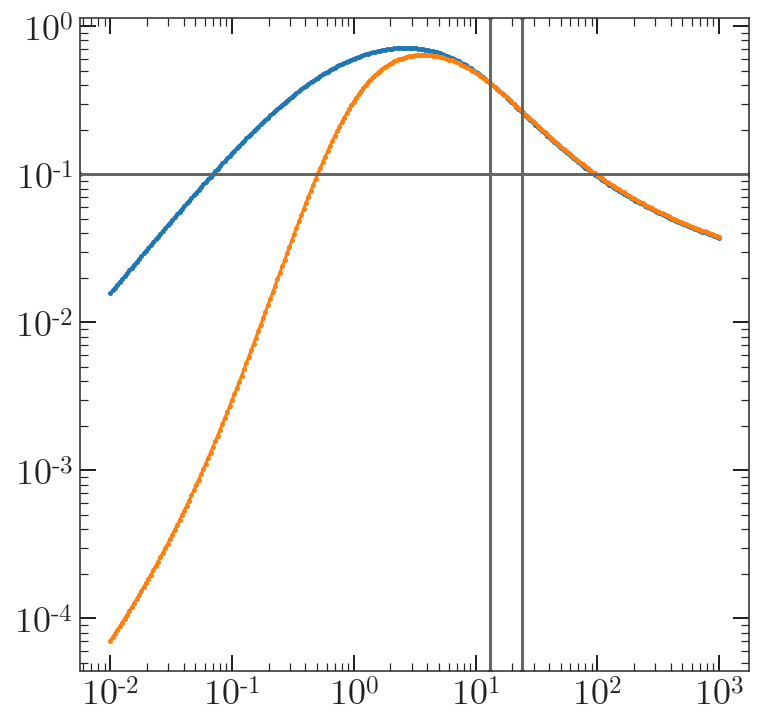

In [68]:
xyz = np.zeros((3, 256))
xyz[0] = np.logspace(-2, 3, xyz.shape[1])

H = model.get_hamiltonian(**potential_p0)
pot = H.potential

# plt.loglog(xyz[0], pot.density(xyz))
# plt.loglog(xyz[0], gp.MilkyWayPotential().density(xyz))

plt.loglog(xyz[0], pot['disk'].gradient(xyz)[0] / pot.gradient(xyz)[0])
plt.loglog(xyz[0], mw['disk'].gradient(xyz)[0] / mw.gradient(xyz)[0])

plt.axvline(orbit.pericenter().value)
plt.axvline(orbit.apocenter().value)

plt.axhline(0.1)

In [69]:
model.ln_prior({'w0': w0_p0, 'potential': potential_p0})

-22.10426767885557

In [70]:
%%time
model.ln_likelihood({'w0': w0_p0, 'potential': potential_p0})

CPU times: user 2.33 s, sys: 19.4 ms, total: 2.35 s
Wall time: 2.39 s


-2600.7763290568714

In [71]:
p0 = model.pack_pars({'w0': w0_p0, 'potential': potential_p0}, 
                     fill_frozen=False)
p0

array([ 3.53709061e-02,  8.89700000e+00, -1.00000000e+01, -2.27160328e+00,
       -1.38114555e+02,  2.50407540e+01,  1.00000000e+00,  2.71201955e+01,
        2.70805020e+00])

In [72]:
model(p0)

-2630.154439217525

In [73]:
%%time
#    bounds=[(-2, 2), (5, 12), (-20, 0), 
#            (-10, 10), (-200, 200), 
#            (0.5, 1.5), (0.5, 1.999), (24, 30)],
res = minimize(lambda *x: -model(*x), x0=p0, 
               method='powell')

CPU times: user 1h 3min 16s, sys: 37.5 s, total: 1h 3min 54s
Wall time: 1h 10min 39s


In [74]:
res

   direc: array([[1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1.]])
     fun: 490.44483860173534
 message: 'Optimization terminated successfully.'
    nfev: 1780
     nit: 6
  status: 0
 success: True
       x: array([ 1.27168892e-01,  8.81723528e+00, -1.15761226e+01, -2.51057530e+00,
       -1.62145386e+02,  2.55806167e+01,  1.45342154e+00,  2.71223658e+01,
        2.77342501e+00])

In [75]:
fit_p = model.unpack_pars(res.x)

In [79]:
fit_p

{'w0': {'phi2': 0.12716889157882055,
  'distance': 8.81723527532562,
  'pm_phi1_cosphi2': -11.576122612503559,
  'pm_phi2': -2.5105753010704452,
  'radial_velocity': -162.1453863232979},
 'potential': {'disk': {'a': 3.0, 'b': 0.28, 'm': 128682847895.60304},
  'halo': {'a': 1.0,
   'b': 1,
   'c': 1.45342154251265,
   'm': 601303614092.3599,
   'r_s': 16.013386267833617}}}

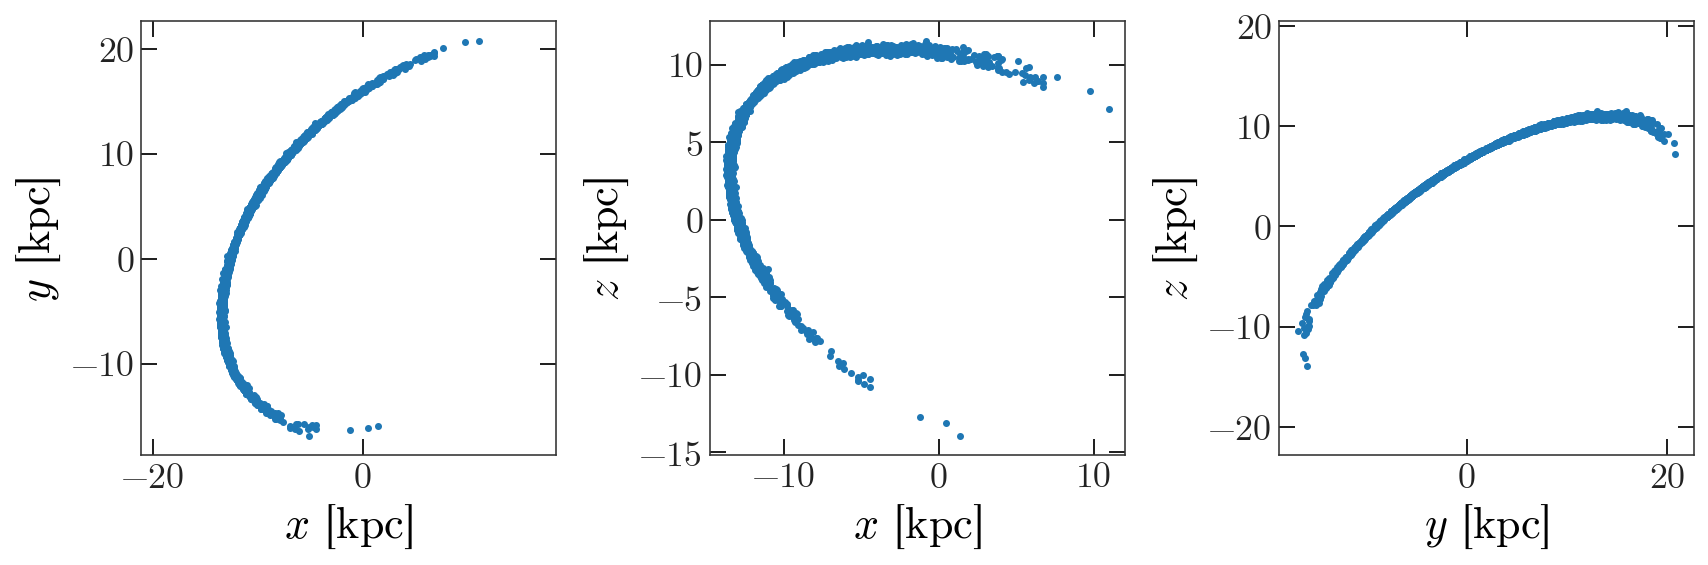

In [76]:
w0 = model.get_w0(**fit_p['w0'])
H = model.get_hamiltonian(**fit_p['potential'])
orbit = model.get_orbit(H, w0)
stream = model.get_mockstream(H, orbit[::-1])
stream_c = stream.to_coord_frame(model.stream_frame, 
                                 galactocentric_frame=model.galcen_frame)
_ = stream.plot()

(5, 15)

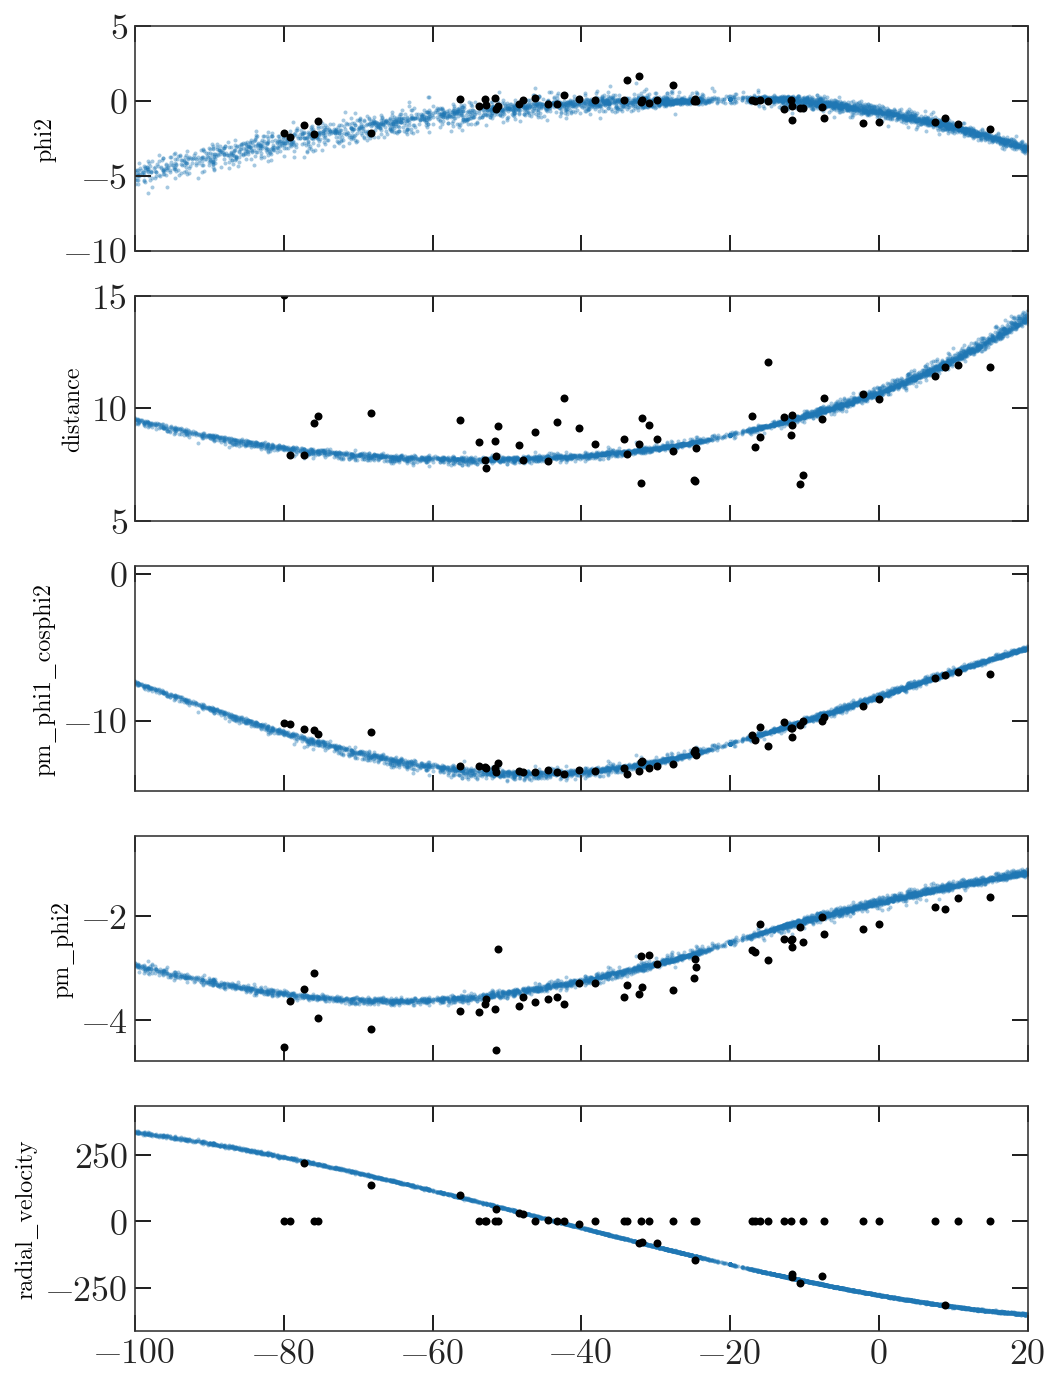

In [77]:
fig, axes = plt.subplots(5, 1, figsize=(8, 12), 
                         sharex=True)

for i, name in enumerate(model._frame_comp_names[1:]):
    ax = axes[i]
    
    ax.plot(model.data['phi1'], model.data[name], 
            marker='o', ls='none', color='k', ms=4)
    
    ax.plot(stream_c.phi1.wrap_at(180*u.deg).degree,
            getattr(stream_c, name).value, 
            marker='o', ls='none', color='tab:blue', ms=2, alpha=0.4, zorder=-100)
    ax.set_ylabel(name, fontsize=12)

ax.set_xlim(-100, 20)
axes[0].set_ylim(-10, 5)
axes[1].set_ylim(5, 15)

(-10, 5)

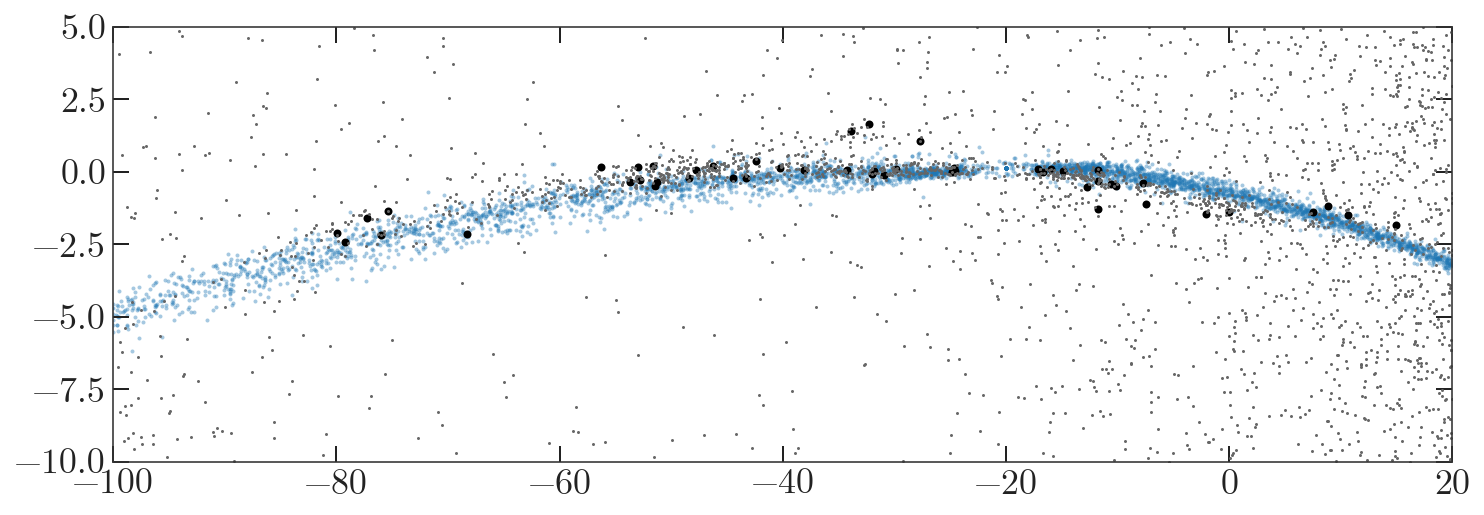

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

ax.plot(model.data['phi1'], model.data['phi2'], 
        marker='o', ls='none', color='k', ms=4)

ax.plot(msto.phi1, msto.phi2,
        marker='o', ls='none', color='#666666', ms=1.5)

ax.plot(stream_c.phi1.wrap_at(180*u.deg).degree,
        stream_c.phi2.value, 
        marker='o', ls='none', color='tab:blue', ms=2, alpha=0.4, zorder=-100)

ax.set_xlim(-100, 20)
ax.set_ylim(-10, 5)

---

In [85]:
res.x

array([ 1.27168892e-01,  8.81723528e+00, -1.15761226e+01, -2.51057530e+00,
       -1.62145386e+02,  2.55806167e+01,  1.45342154e+00,  2.71223658e+01,
        2.77342501e+00])

In [ ]:
nwalkers = 64
ndim = len(p0)
p0s = emcee.utils.sample_ball(p0, [1e-3]*ndim, size=nwalkers)

In [ ]:
def _worker(pp):
    assert np.isfinite(model(pp))

with schwimmbad.MultiPool() as pool:
    for _ in pool.map(_worker, p0s):
        pass

In [ ]:
with schwimmbad.MultiPool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim=ndim, 
                                    log_prob_fn=model,
                                    pool=pool)
    sampler.run_mcmc(p0s, 512)

In [ ]:
fig, axes = plt.subplots(sampler.ndim, 1, figsize=(8, 2*sampler.ndim),
                         sharex=True)
for k in range(sampler.ndim):
    for walker in sampler.chain[..., k]:
        axes[k].plot(walker, marker='', drawstyle='steps-mid', 
                     color='k', alpha=0.2)
        
fig.tight_layout()

In [ ]:
# with open('fit-stream-track-chain.pkl', 'wb') as f:
#     pickle.dump(sampler.chain, f)

In [ ]:
comp_names = (list(orbit_c.get_representation_component_names()) + 
              list(orbit_c.get_representation_component_names('s')))

fig, axes = plt.subplots(5, 1, figsize=(12, 12,), 
                         sharex=True)

for i, attr in enumerate(comp_names[1:]):
    ax = axes[i]
    ax.plot(c_gd1.phi1.wrap_at(180*u.deg).degree,
            getattr(c_gd1, attr).value,
            marker='o', ls='none')
    
# for pp in sampler.chain[:, -1][:16]:
for pp in [res.x]:
    w0 = model.get_w0(pp)
    _orbit = ham.integrate_orbit(w0, dt=-0.5*u.Myr, n_steps=200)
    orbit = ham.integrate_orbit(_orbit[-1], dt=0.5*u.Myr, n_steps=400)
    orbit_c = orbit.to_coord_frame(gc.GD1, galactocentric_frame=model.galcen_frame)

    for i, attr in enumerate(comp_names[1:]):
        ax = axes[i]
        ax.plot(orbit_c.phi1.wrap_at(180*u.deg).degree,
                getattr(orbit_c, attr).to_value(getattr(c_gd1, attr).unit),
                marker='', ls='-', alpha=0.5, color='tab:orange')

In [ ]:
# model2 = MockStreamModel(data, stream_frame=gc.GD1(),
#                         potential=gp.MilkyWayPotential(), 
#                         dt=-0.5*u.Myr, n_steps=6000, phi1_0=-20*u.deg,
#                         galcen_frame=galcen_frame, release_every=2,
#                         phi1_lim=[-100, 20]*u.deg, phi1_binsize=2*u.deg)

In [ ]:
%%time
pp = res.x
stream = model.get_mockstream(pp)

In [ ]:
fig, axes = plt.subplots(5, 1, figsize=(12, 12,), 
                         sharex=True)

_unit = {'phi2': u.deg, 'distance': u.kpc, 
         'pm_phi1_cosphi2': u.mas/u.yr,
         'pm_phi2': u.mas/u.yr,
         'radial_velocity': u.km/u.s}
_lim = {'phi2': (-10, 5), 
        'distance': (5, 20), 
        'pm_phi1_cosphi2': (-15, -5),
        'pm_phi2': (-10, 0),
        'radial_velocity': (-350, 350)}

for i, attr in enumerate(comp_names[1:]):
    ax = axes[i]
    ax.plot(c_gd1.phi1.wrap_at(180*u.deg).degree,
            getattr(c_gd1, attr).to_value(_unit[attr]),
            marker='o', ls='none', color='k', zorder=100)
    
stream_c = stream.to_coord_frame(gc.GD1, 
                                 galactocentric_frame=model.galcen_frame)

for i, attr in enumerate(comp_names[1:]):
    ax = axes[i]
    ax.plot(stream_c.phi1.wrap_at(180*u.deg).degree,
            getattr(stream_c, attr).to_value(_unit[attr]),
            marker='o', ls='none', ms=1., alpha=0.5, 
            color='#aaaaaa', zorder=10)
    
    ax.set_ylim(_lim[attr])
    
ax.set_xlim(-100, 20)